In [4]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay

import scikitplot as skplt

import optuna
from optuna.trial import TrialState

##### Carregando o dataset

In [5]:
df_train = pd.read_csv('../data/treated_data/train.csv')
df_val = pd.read_csv('../data/treated_data/validation.csv')
df_test = pd.read_csv('../data/treated_data/test.csv')

In [6]:
X_train = df_train.drop(['satisfaction'], axis=1)
y_train = df_train['satisfaction'].values

X_val = df_val.drop(['satisfaction'], axis=1)
y_val = df_val['satisfaction'].values

X_test = df_test.drop(['satisfaction'], axis=1)
y_test = df_test['satisfaction'].values

#### Declarando as funções de avaliação do modelo

In [7]:
def plot_roc_curve(y_pred: np.array, y_test: np.array) -> None:
    
    # Obter as probabilidades da classe positiva
    y_pred_positive = y_pred[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_positive)
    roc_auc = roc_auc_score(y_test, y_pred_positive)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})' )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()



In [8]:
def plot_confusion_matrix(y_pred: np.array, y_test: np.array) -> None:
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Unsatisfied', 'Satisfied'], yticklabels=['Unsatisfied', 'Satisfied'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [9]:
def compute_performance_metrics(y, y_pred_class, y_pred_scores=None):
    accuracy = accuracy_score(y, y_pred_class)
    recall = recall_score(y, y_pred_class)
    precision = precision_score(y, y_pred_class)
    f1 = f1_score(y, y_pred_class)
    performance_metrics = (accuracy, recall, precision, f1)
    if y_pred_scores is not None:
        skplt.metrics.plot_ks_statistic(y, y_pred_scores)
        plt.show()
        y_pred_scores = y_pred_scores[:, 1]
        auroc = roc_auc_score(y, y_pred_scores)
        aupr = average_precision_score(y, y_pred_scores)
        performance_metrics = performance_metrics + (auroc, aupr)
    return performance_metrics

In [10]:
def print_metrics_summary(accuracy, recall, precision, f1, auroc=None, aupr=None):
    print()
    print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy))
    print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall))
    print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision))
    print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1))
    if auroc is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=auroc))
    if aupr is not None:
        print("{metric:<18}{value:.4f}".format(metric="AUPR:", value=aupr))

##### Ajustando variáveis one-hot-encoding para string

In [11]:
columns_to_concat = [
    'Age',
    'Flight Distance',
    'Departure Delay in Minutes',
    'Arrival Delay in Minutes',
    'Gender',
    'Customer Type',
    'Type of Travel',
    'Class'
]

In [12]:
def one_hot_to_string(df: pd.DataFrame, col: list) -> pd.DataFrame:
    for prefix in col:
        cols_to_concat = [c for c in df.columns if c.startswith(prefix + '_')]
        
        if cols_to_concat:
            df[prefix] = df[cols_to_concat].astype(str).agg(''.join, axis=1)
            
            df.drop(cols_to_concat, axis=1, inplace=True)
            
    return df

In [13]:
X_train = one_hot_to_string(df=X_train, col=columns_to_concat)
X_val = one_hot_to_string(df=X_val, col=columns_to_concat)
X_test = one_hot_to_string(df=X_test, col=columns_to_concat)

In [14]:
X_train.columns

Index(['Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'Cleanliness', 'Age',
       'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Gender', 'Customer Type', 'Type of Travel',
       'Class'],
      dtype='object')

In [15]:
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

##### Criando o modelo xgboost base

Utilizaremos configurações similares a configuração base do random forest, para comparação

In [47]:
params = {
    'max_depth': 10,
    'eta': 0.1,  #Learning Rate
    'objective': 'binary:logistic', # Escolha para classificação binária
    'eval_metric': 'auc'            # Avaliando via AUC
}

##### Criando instância DMatrix

In [48]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

In [49]:
model = xgb.train(params, dtrain, 50, evals=[(dval, 'validation')], early_stopping_rounds=5)


[0]	validation-auc:0.98732


[1]	validation-auc:0.98779
[2]	validation-auc:0.98877
[3]	validation-auc:0.98898
[4]	validation-auc:0.98917
[5]	validation-auc:0.98932
[6]	validation-auc:0.98960
[7]	validation-auc:0.98976
[8]	validation-auc:0.99003
[9]	validation-auc:0.99028
[10]	validation-auc:0.99051
[11]	validation-auc:0.99060
[12]	validation-auc:0.99083
[13]	validation-auc:0.99097
[14]	validation-auc:0.99113
[15]	validation-auc:0.99124
[16]	validation-auc:0.99158
[17]	validation-auc:0.99179
[18]	validation-auc:0.99194
[19]	validation-auc:0.99204
[20]	validation-auc:0.99219
[21]	validation-auc:0.99229
[22]	validation-auc:0.99244
[23]	validation-auc:0.99254
[24]	validation-auc:0.99262
[25]	validation-auc:0.99268
[26]	validation-auc:0.99275
[27]	validation-auc:0.99281
[28]	validation-auc:0.99289
[29]	validation-auc:0.99293
[30]	validation-auc:0.99299
[31]	validation-auc:0.99303
[32]	validation-auc:0.99306
[33]	validation-auc:0.99308
[34]	validation-auc:0.99313
[35]	validation-auc:0.99314
[36]	validation-auc:0.99317
[

#### Avaliando o Modelo


In [50]:
xgb_pred_scores = model.predict(dtest)

# Calculando a probabilidade da classe negativa
neg_class_probs = 1 - xgb_pred_scores

# Concatenando as duas arrays para formar um array 2D
xgb_pred_scores = np.vstack((neg_class_probs, xgb_pred_scores)).T
xgb_pred_class = np.argmax(xgb_pred_scores, axis=1)

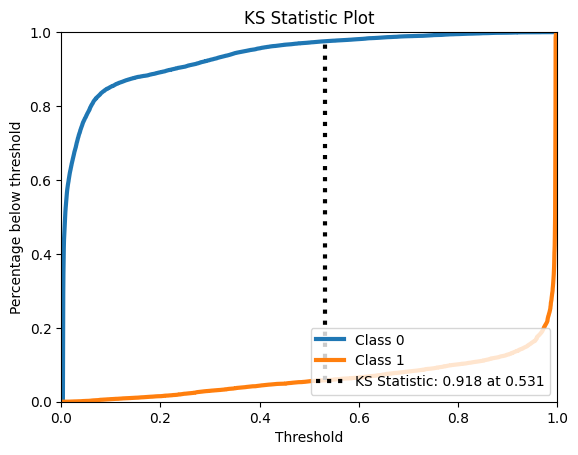



xgboost - Test

Accuracy:         0.9599
Recall:           0.9445
Precision:        0.9625
F1:               0.9534
AUROC:            0.9942
AUPR:             0.9932


In [51]:
accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, xgb_pred_class, xgb_pred_scores)
print('\n\nxgboost - Test')
print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)

#### Usando o Optune para encontrar os melhores Hiperparâmetros

In [53]:
def objective(trial):

    global dtrain
    global dval
    global dtest
    global y_test

    params = {
        'max_depth': trial.suggest_int('max_depth', 3,  50),
        'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate
        'objective': 'binary:logistic', # Escolha para classificação binária
        'eval_metric': 'auc',        # Avaliando via AUC
        'lambda' : trial.suggest_int('lambda', 1,  5), # L2 regularization term on weights
        'alpha' : trial.suggest_int('alpha', 1,  5),
        'grow_policy' : trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
    }



    trial.set_user_attr("max_depth", params["max_depth"])
    trial.set_user_attr("eta", params["eta"])
    trial.set_user_attr("lambda", params["lambda"])
    trial.set_user_attr("alpha", params["alpha"])
    trial.set_user_attr("grow_policy", params["grow_policy"])

    
    # Criar o modelo RandomForest com os hiperparâmetros sugeridos
    model = xgb.train(params, dtrain, 100, evals=[(dval, 'validation')], early_stopping_rounds=5)

    
    xgb_pred_scores = model.predict(dtest)

    neg_class_probs = 1 - xgb_pred_scores

    xgb_pred_scores = np.vstack((neg_class_probs, xgb_pred_scores)).T
    xgb_pred_class = np.argmax(xgb_pred_scores, axis=1)

    accuracy, recall, precision, f1, auroc, aupr = compute_performance_metrics(y_test, xgb_pred_class, xgb_pred_scores)
    print(f'\n\nRandom Forest\neta: {params["eta"]}\nmax_depth:{params["max_depth"]}\nlambda:{params["lambda"]}\nalpha:{params["alpha"]}\ngrow_policy:{params["grow_policy"]}')
    print_metrics_summary(accuracy, recall, precision, f1, auroc, aupr)
    

    trial.set_user_attr("accuracy", accuracy)
    trial.set_user_attr("recall", recall)
    trial.set_user_attr("precision", precision)
    trial.set_user_attr("f1", precision)
    trial.set_user_attr("auroc", auroc)
    
    return auroc


[I 2024-07-17 20:33:05,264] A new study created in memory with name: no-name-811d1812-5873-4ecd-9db7-af3c42b00c1e


[0]	validation-auc:0.98891
[1]	validation-auc:0.99032
[2]	validation-auc:0.99077
[3]	validation-auc:0.99115
[4]	validation-auc:0.99121
[5]	validation-auc:0.99145


/tmp/ipykernel_9200/3566091510.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[6]	validation-auc:0.99178
[7]	validation-auc:0.99244
[8]	validation-auc:0.99270
[9]	validation-auc:0.99298
[10]	validation-auc:0.99311
[11]	validation-auc:0.99322
[12]	validation-auc:0.99331
[13]	validation-auc:0.99343
[14]	validation-auc:0.99347
[15]	validation-auc:0.99353
[16]	validation-auc:0.99355
[17]	validation-auc:0.99361
[18]	validation-auc:0.99367
[19]	validation-auc:0.99373
[20]	validation-auc:0.99375
[21]	validation-auc:0.99379
[22]	validation-auc:0.99384
[23]	validation-auc:0.99385
[24]	validation-auc:0.99386
[25]	validation-auc:0.99387
[26]	validation-auc:0.99389
[27]	validation-auc:0.99390
[28]	validation-auc:0.99390
[29]	validation-auc:0.99390
[30]	validation-auc:0.99391
[31]	validation-auc:0.99392
[32]	validation-auc:0.99394
[33]	validation-auc:0.99394
[34]	validation-auc:0.99397
[35]	validation-auc:0.99398
[36]	validation-auc:0.99400
[37]	validation-auc:0.99401
[38]	validation-auc:0.99400
[39]	validation-auc:0.99400
[40]	validation-auc:0.99401
[41]	validation-auc:0.99

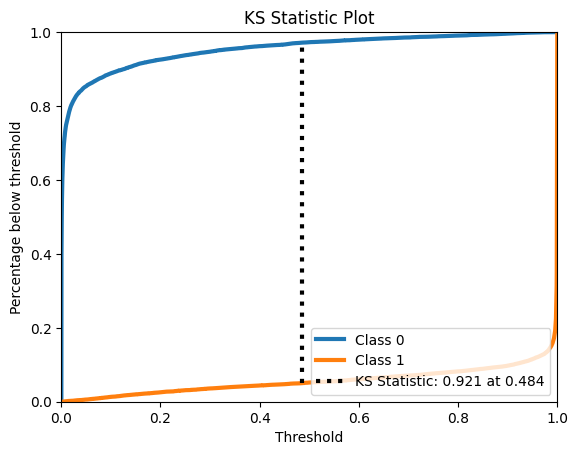

[I 2024-07-17 20:33:06,799] Trial 0 finished with value: 0.9947748986446817 and parameters: {'max_depth': 36, 'eta': 0.2, 'lambda': 2, 'alpha': 1, 'grow_policy': 'depthwise'}. Best is trial 0 with value: 0.9947748986446817.




Random Forest
eta: 0.2
max_depth:36
lambda:2
alpha:1
grow_policy:depthwise

Accuracy:         0.9619
Recall:           0.9480
Precision:        0.9638
F1:               0.9558
AUROC:            0.9948
AUPR:             0.9938
[0]	validation-auc:0.96725
[1]	validation-auc:0.97039
[2]	validation-auc:0.97345
[3]	validation-auc:0.97572
[4]	validation-auc:0.97655
[5]	validation-auc:0.97777
[6]	validation-auc:0.98056
[7]	validation-auc:0.98202
[8]	validation-auc:0.98345
[9]	validation-auc:0.98426
[10]	validation-auc:0.98493


/tmp/ipykernel_9200/3566091510.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[11]	validation-auc:0.98570
[12]	validation-auc:0.98590
[13]	validation-auc:0.98620
[14]	validation-auc:0.98676
[15]	validation-auc:0.98714
[16]	validation-auc:0.98750
[17]	validation-auc:0.98771
[18]	validation-auc:0.98796
[19]	validation-auc:0.98816
[20]	validation-auc:0.98834
[21]	validation-auc:0.98852
[22]	validation-auc:0.98900
[23]	validation-auc:0.98919
[24]	validation-auc:0.98939
[25]	validation-auc:0.98971
[26]	validation-auc:0.98990
[27]	validation-auc:0.99018
[28]	validation-auc:0.99028
[29]	validation-auc:0.99035
[30]	validation-auc:0.99044
[31]	validation-auc:0.99062
[32]	validation-auc:0.99066
[33]	validation-auc:0.99083
[34]	validation-auc:0.99088
[35]	validation-auc:0.99088
[36]	validation-auc:0.99108
[37]	validation-auc:0.99116
[38]	validation-auc:0.99120
[39]	validation-auc:0.99137
[40]	validation-auc:0.99143
[41]	validation-auc:0.99166
[42]	validation-auc:0.99169
[43]	validation-auc:0.99175
[44]	validation-auc:0.99184
[45]	validation-auc:0.99187
[46]	validation-auc:

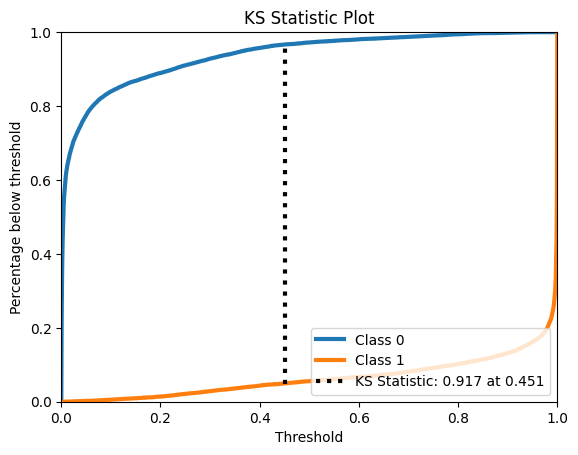

[I 2024-07-17 20:33:08,399] Trial 1 finished with value: 0.9942361061256871 and parameters: {'max_depth': 5, 'eta': 0.2, 'lambda': 2, 'alpha': 2, 'grow_policy': 'lossguide'}. Best is trial 0 with value: 0.9947748986446817.




Random Forest
eta: 0.2
max_depth:5
lambda:2
alpha:2
grow_policy:lossguide

Accuracy:         0.9600
Recall:           0.9444
Precision:        0.9628
F1:               0.9535
AUROC:            0.9942
AUPR:             0.9932
[0]	validation-auc:0.98789
[1]	validation-auc:0.98863
[2]	validation-auc:0.98896
[3]	validation-auc:0.98954
[4]	validation-auc:0.98991
[5]	validation-auc:0.99031
[6]	validation-auc:0.99078


/tmp/ipykernel_9200/3566091510.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[7]	validation-auc:0.99118
[8]	validation-auc:0.99142
[9]	validation-auc:0.99167
[10]	validation-auc:0.99195
[11]	validation-auc:0.99212
[12]	validation-auc:0.99222
[13]	validation-auc:0.99237
[14]	validation-auc:0.99276
[15]	validation-auc:0.99291
[16]	validation-auc:0.99309
[17]	validation-auc:0.99316
[18]	validation-auc:0.99323
[19]	validation-auc:0.99330
[20]	validation-auc:0.99339
[21]	validation-auc:0.99346
[22]	validation-auc:0.99352
[23]	validation-auc:0.99357
[24]	validation-auc:0.99363
[25]	validation-auc:0.99367
[26]	validation-auc:0.99373
[27]	validation-auc:0.99375
[28]	validation-auc:0.99378
[29]	validation-auc:0.99384
[30]	validation-auc:0.99389
[31]	validation-auc:0.99393
[32]	validation-auc:0.99395
[33]	validation-auc:0.99396
[34]	validation-auc:0.99399
[35]	validation-auc:0.99402
[36]	validation-auc:0.99404
[37]	validation-auc:0.99406
[38]	validation-auc:0.99409
[39]	validation-auc:0.99411
[40]	validation-auc:0.99415
[41]	validation-auc:0.99416
[42]	validation-auc:0.9

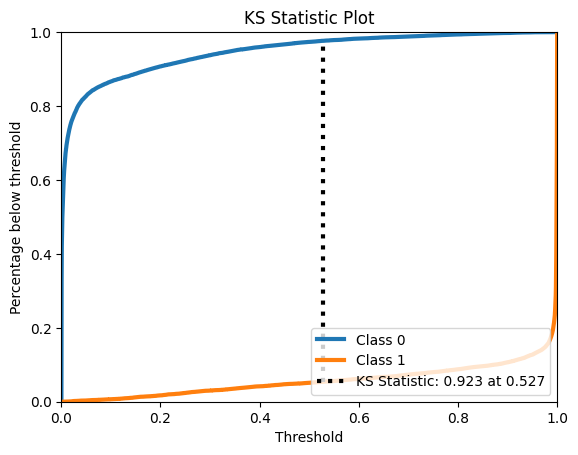

[I 2024-07-17 20:33:10,766] Trial 2 finished with value: 0.9949929904761896 and parameters: {'max_depth': 47, 'eta': 0.15000000000000002, 'lambda': 2, 'alpha': 4, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.9949929904761896.




Random Forest
eta: 0.15000000000000002
max_depth:47
lambda:2
alpha:4
grow_policy:lossguide

Accuracy:         0.9628
Recall:           0.9488
Precision:        0.9649
F1:               0.9568
AUROC:            0.9950
AUPR:             0.9941
[0]	validation-auc:0.98373
[1]	validation-auc:0.98466
[2]	validation-auc:0.98508
[3]	validation-auc:0.98593
[4]	validation-auc:0.98848
[5]	validation-auc:0.98861
[6]	validation-auc:0.98883
[7]	validation-auc:0.98892
[8]	validation-auc:0.98904


/tmp/ipykernel_9200/3566091510.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[9]	validation-auc:0.98914
[10]	validation-auc:0.98933
[11]	validation-auc:0.98945
[12]	validation-auc:0.98949
[13]	validation-auc:0.98962
[14]	validation-auc:0.98988
[15]	validation-auc:0.99001
[16]	validation-auc:0.99004
[17]	validation-auc:0.99018
[18]	validation-auc:0.99034
[19]	validation-auc:0.99051
[20]	validation-auc:0.99064
[21]	validation-auc:0.99078
[22]	validation-auc:0.99090
[23]	validation-auc:0.99099
[24]	validation-auc:0.99113
[25]	validation-auc:0.99122
[26]	validation-auc:0.99128
[27]	validation-auc:0.99135
[28]	validation-auc:0.99146
[29]	validation-auc:0.99155
[30]	validation-auc:0.99164
[31]	validation-auc:0.99171
[32]	validation-auc:0.99179
[33]	validation-auc:0.99185
[34]	validation-auc:0.99191
[35]	validation-auc:0.99196
[36]	validation-auc:0.99200
[37]	validation-auc:0.99203
[38]	validation-auc:0.99228
[39]	validation-auc:0.99236
[40]	validation-auc:0.99241
[41]	validation-auc:0.99247
[42]	validation-auc:0.99252
[43]	validation-auc:0.99257
[44]	validation-auc:0

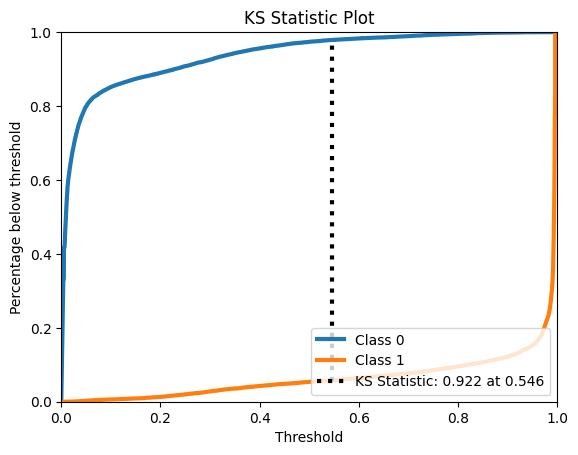

[I 2024-07-17 20:33:13,438] Trial 3 finished with value: 0.994595307572193 and parameters: {'max_depth': 44, 'eta': 0.05, 'lambda': 4, 'alpha': 4, 'grow_policy': 'lossguide'}. Best is trial 2 with value: 0.9949929904761896.




Random Forest
eta: 0.05
max_depth:44
lambda:4
alpha:4
grow_policy:lossguide

Accuracy:         0.9617
Recall:           0.9461
Precision:        0.9652
F1:               0.9555
AUROC:            0.9946
AUPR:             0.9937
[0]	validation-auc:0.98819
[1]	validation-auc:0.98975
[2]	validation-auc:0.99023
[3]	validation-auc:0.99080
[4]	validation-auc:0.99157
[5]	validation-auc:0.99180
[6]	validation-auc:0.99213
[7]	validation-auc:0.99236
[8]	validation-auc:0.99262
[9]	validation-auc:0.99302
[10]	validation-auc:0.99320


/tmp/ipykernel_9200/3566091510.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[11]	validation-auc:0.99333
[12]	validation-auc:0.99340
[13]	validation-auc:0.99354
[14]	validation-auc:0.99361
[15]	validation-auc:0.99369
[16]	validation-auc:0.99373
[17]	validation-auc:0.99379
[18]	validation-auc:0.99382
[19]	validation-auc:0.99385
[20]	validation-auc:0.99390
[21]	validation-auc:0.99397
[22]	validation-auc:0.99402
[23]	validation-auc:0.99405
[24]	validation-auc:0.99408
[25]	validation-auc:0.99412
[26]	validation-auc:0.99414
[27]	validation-auc:0.99415
[28]	validation-auc:0.99415
[29]	validation-auc:0.99418
[30]	validation-auc:0.99419
[31]	validation-auc:0.99419
[32]	validation-auc:0.99419
[33]	validation-auc:0.99418
[34]	validation-auc:0.99418
[35]	validation-auc:0.99417


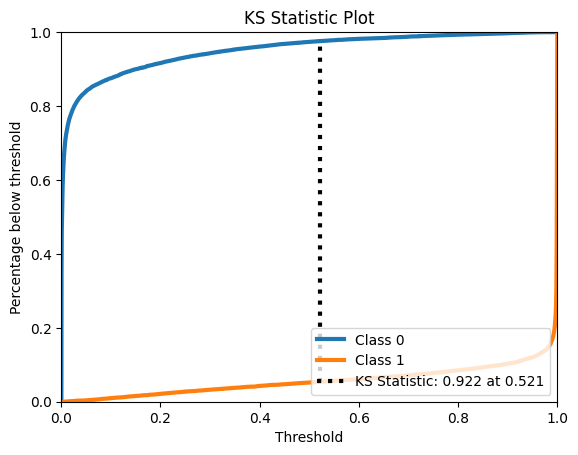

[I 2024-07-17 20:33:14,212] Trial 4 finished with value: 0.9949737429919094 and parameters: {'max_depth': 36, 'eta': 0.25, 'lambda': 3, 'alpha': 2, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.9949929904761896.




Random Forest
eta: 0.25
max_depth:36
lambda:3
alpha:2
grow_policy:depthwise

Accuracy:         0.9625
Recall:           0.9481
Precision:        0.9649
F1:               0.9565
AUROC:            0.9950
AUPR:             0.9941
[0]	validation-auc:0.98891
[1]	validation-auc:0.99017
[2]	validation-auc:0.99054
[3]	validation-auc:0.99067
[4]	validation-auc:0.99080
[5]	validation-auc:0.99097
[6]	validation-auc:0.99100
[7]	validation-auc:0.99116
[8]	validation-auc:0.99119
[9]	validation-auc:0.99126
[10]	validation-auc:0.99134
[11]	validation-auc:0.99150


/tmp/ipykernel_9200/3566091510.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[12]	validation-auc:0.99173
[13]	validation-auc:0.99180
[14]	validation-auc:0.99231
[15]	validation-auc:0.99252
[16]	validation-auc:0.99264
[17]	validation-auc:0.99283
[18]	validation-auc:0.99293
[19]	validation-auc:0.99299
[20]	validation-auc:0.99303
[21]	validation-auc:0.99310
[22]	validation-auc:0.99314
[23]	validation-auc:0.99318
[24]	validation-auc:0.99328
[25]	validation-auc:0.99333
[26]	validation-auc:0.99342
[27]	validation-auc:0.99345
[28]	validation-auc:0.99350
[29]	validation-auc:0.99353
[30]	validation-auc:0.99355
[31]	validation-auc:0.99357
[32]	validation-auc:0.99358
[33]	validation-auc:0.99360
[34]	validation-auc:0.99363
[35]	validation-auc:0.99364
[36]	validation-auc:0.99367
[37]	validation-auc:0.99370
[38]	validation-auc:0.99373
[39]	validation-auc:0.99375
[40]	validation-auc:0.99375
[41]	validation-auc:0.99377
[42]	validation-auc:0.99378
[43]	validation-auc:0.99380
[44]	validation-auc:0.99381
[45]	validation-auc:0.99383
[46]	validation-auc:0.99384
[47]	validation-auc:

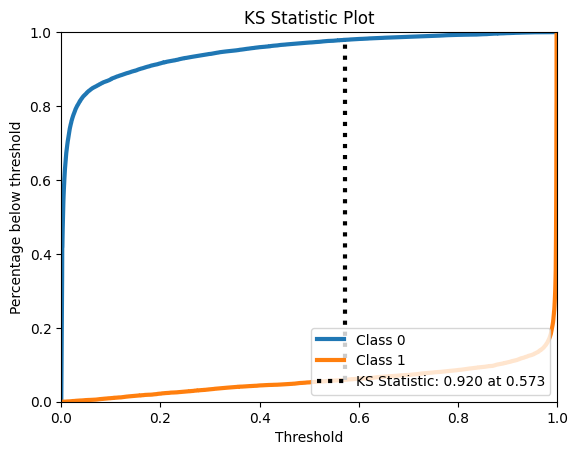

[I 2024-07-17 20:33:15,576] Trial 5 finished with value: 0.9946480663703596 and parameters: {'max_depth': 40, 'eta': 0.1, 'lambda': 2, 'alpha': 1, 'grow_policy': 'depthwise'}. Best is trial 2 with value: 0.9949929904761896.




Random Forest
eta: 0.1
max_depth:40
lambda:2
alpha:1
grow_policy:depthwise

Accuracy:         0.9613
Recall:           0.9477
Precision:        0.9626
F1:               0.9551
AUROC:            0.9946
AUPR:             0.9937
[0]	validation-auc:0.98386
[1]	validation-auc:0.98828
[2]	validation-auc:0.98907
[3]	validation-auc:0.98943
[4]	validation-auc:0.99005
[5]	validation-auc:0.99087


/tmp/ipykernel_9200/3566091510.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[6]	validation-auc:0.99106
[7]	validation-auc:0.99148
[8]	validation-auc:0.99182
[9]	validation-auc:0.99231
[10]	validation-auc:0.99254
[11]	validation-auc:0.99262
[12]	validation-auc:0.99284
[13]	validation-auc:0.99299
[14]	validation-auc:0.99311
[15]	validation-auc:0.99321
[16]	validation-auc:0.99338
[17]	validation-auc:0.99347
[18]	validation-auc:0.99355
[19]	validation-auc:0.99368
[20]	validation-auc:0.99373
[21]	validation-auc:0.99380
[22]	validation-auc:0.99385
[23]	validation-auc:0.99390
[24]	validation-auc:0.99393
[25]	validation-auc:0.99399
[26]	validation-auc:0.99403
[27]	validation-auc:0.99406
[28]	validation-auc:0.99408
[29]	validation-auc:0.99411
[30]	validation-auc:0.99415
[31]	validation-auc:0.99419
[32]	validation-auc:0.99422
[33]	validation-auc:0.99423
[34]	validation-auc:0.99424
[35]	validation-auc:0.99424
[36]	validation-auc:0.99425
[37]	validation-auc:0.99427
[38]	validation-auc:0.99430
[39]	validation-auc:0.99430
[40]	validation-auc:0.99429
[41]	validation-auc:0.99

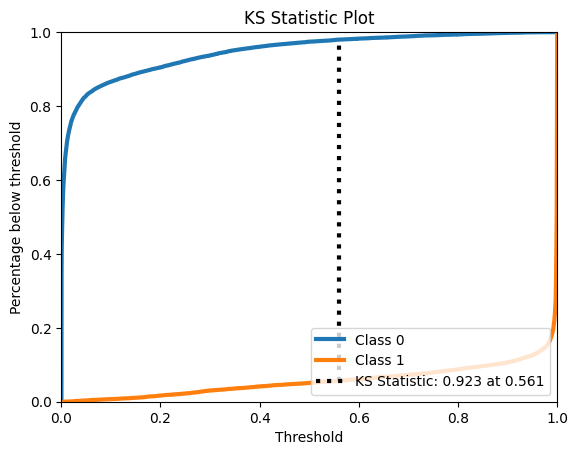

[I 2024-07-17 20:33:17,424] Trial 6 finished with value: 0.9950711172733429 and parameters: {'max_depth': 22, 'eta': 0.2, 'lambda': 3, 'alpha': 5, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.9950711172733429.




Random Forest
eta: 0.2
max_depth:22
lambda:3
alpha:5
grow_policy:lossguide

Accuracy:         0.9632
Recall:           0.9491
Precision:        0.9657
F1:               0.9573
AUROC:            0.9951
AUPR:             0.9942
[0]	validation-auc:0.98468
[1]	validation-auc:0.98503
[2]	validation-auc:0.98771
[3]	validation-auc:0.98814
[4]	validation-auc:0.98897
[5]	validation-auc:0.98904
[6]	validation-auc:0.98916
[7]	validation-auc:0.98929
[8]	validation-auc:0.98929


/tmp/ipykernel_9200/3566091510.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[9]	validation-auc:0.98960
[10]	validation-auc:0.98966
[11]	validation-auc:0.98988
[12]	validation-auc:0.98997
[13]	validation-auc:0.99004
[14]	validation-auc:0.99007
[15]	validation-auc:0.99015
[16]	validation-auc:0.99037
[17]	validation-auc:0.99054
[18]	validation-auc:0.99062
[19]	validation-auc:0.99078
[20]	validation-auc:0.99082
[21]	validation-auc:0.99087
[22]	validation-auc:0.99100
[23]	validation-auc:0.99115
[24]	validation-auc:0.99128
[25]	validation-auc:0.99135
[26]	validation-auc:0.99142
[27]	validation-auc:0.99149
[28]	validation-auc:0.99157
[29]	validation-auc:0.99171
[30]	validation-auc:0.99178
[31]	validation-auc:0.99186
[32]	validation-auc:0.99192
[33]	validation-auc:0.99198
[34]	validation-auc:0.99203
[35]	validation-auc:0.99208
[36]	validation-auc:0.99211
[37]	validation-auc:0.99214
[38]	validation-auc:0.99218
[39]	validation-auc:0.99243
[40]	validation-auc:0.99248
[41]	validation-auc:0.99251
[42]	validation-auc:0.99258
[43]	validation-auc:0.99265
[44]	validation-auc:0

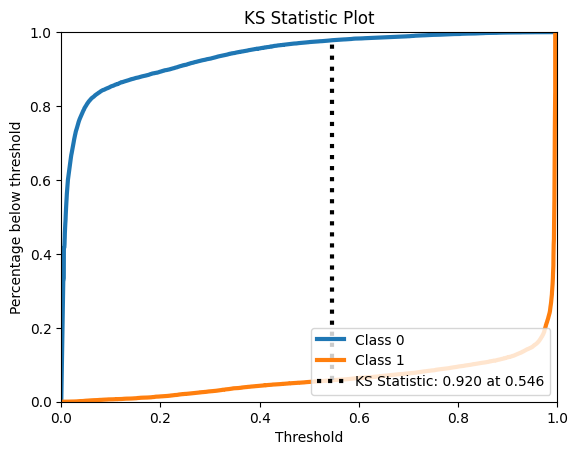

[I 2024-07-17 20:33:19,870] Trial 7 finished with value: 0.9946169098429577 and parameters: {'max_depth': 40, 'eta': 0.05, 'lambda': 4, 'alpha': 3, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.9950711172733429.




Random Forest
eta: 0.05
max_depth:40
lambda:4
alpha:3
grow_policy:depthwise

Accuracy:         0.9614
Recall:           0.9463
Precision:        0.9641
F1:               0.9551
AUROC:            0.9946
AUPR:             0.9937
[0]	validation-auc:0.98236
[1]	validation-auc:0.98649
[2]	validation-auc:0.98744
[3]	validation-auc:0.98779
[4]	validation-auc:0.98818
[5]	validation-auc:0.98852
[6]	validation-auc:0.98900
[7]	validation-auc:0.98918
[8]	validation-auc:0.98985
[9]	validation-auc:0.99008
[10]	validation-auc:0.99074
[11]	validation-auc:0.99109


/tmp/ipykernel_9200/3566091510.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[12]	validation-auc:0.99129
[13]	validation-auc:0.99141
[14]	validation-auc:0.99154
[15]	validation-auc:0.99172
[16]	validation-auc:0.99190
[17]	validation-auc:0.99206
[18]	validation-auc:0.99221
[19]	validation-auc:0.99234
[20]	validation-auc:0.99241
[21]	validation-auc:0.99253
[22]	validation-auc:0.99260
[23]	validation-auc:0.99268
[24]	validation-auc:0.99274
[25]	validation-auc:0.99277
[26]	validation-auc:0.99283
[27]	validation-auc:0.99289
[28]	validation-auc:0.99294
[29]	validation-auc:0.99298
[30]	validation-auc:0.99303
[31]	validation-auc:0.99318
[32]	validation-auc:0.99322
[33]	validation-auc:0.99332
[34]	validation-auc:0.99340
[35]	validation-auc:0.99345
[36]	validation-auc:0.99351
[37]	validation-auc:0.99353
[38]	validation-auc:0.99359
[39]	validation-auc:0.99364
[40]	validation-auc:0.99367
[41]	validation-auc:0.99370
[42]	validation-auc:0.99372
[43]	validation-auc:0.99374
[44]	validation-auc:0.99377
[45]	validation-auc:0.99383
[46]	validation-auc:0.99385
[47]	validation-auc:

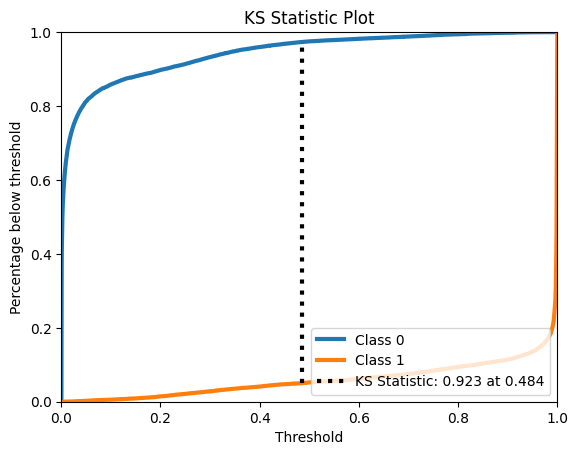

[I 2024-07-17 20:33:21,440] Trial 8 finished with value: 0.9949511254607424 and parameters: {'max_depth': 10, 'eta': 0.15000000000000002, 'lambda': 2, 'alpha': 5, 'grow_policy': 'depthwise'}. Best is trial 6 with value: 0.9950711172733429.




Random Forest
eta: 0.15000000000000002
max_depth:10
lambda:2
alpha:5
grow_policy:depthwise

Accuracy:         0.9630
Recall:           0.9476
Precision:        0.9667
F1:               0.9570
AUROC:            0.9950
AUPR:             0.9940
[0]	validation-auc:0.98690
[1]	validation-auc:0.98892
[2]	validation-auc:0.98933
[3]	validation-auc:0.99019


/tmp/ipykernel_9200/3566091510.py:10: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  'eta': trial.suggest_discrete_uniform('eta', 0.05,  0.3, 0.05),  #Learning Rate


[4]	validation-auc:0.99064
[5]	validation-auc:0.99099
[6]	validation-auc:0.99159
[7]	validation-auc:0.99208
[8]	validation-auc:0.99248
[9]	validation-auc:0.99269
[10]	validation-auc:0.99291
[11]	validation-auc:0.99312
[12]	validation-auc:0.99324
[13]	validation-auc:0.99336
[14]	validation-auc:0.99342
[15]	validation-auc:0.99351
[16]	validation-auc:0.99354
[17]	validation-auc:0.99359
[18]	validation-auc:0.99376
[19]	validation-auc:0.99378
[20]	validation-auc:0.99388
[21]	validation-auc:0.99393
[22]	validation-auc:0.99401
[23]	validation-auc:0.99408
[24]	validation-auc:0.99411
[25]	validation-auc:0.99411
[26]	validation-auc:0.99415
[27]	validation-auc:0.99415
[28]	validation-auc:0.99416
[29]	validation-auc:0.99417
[30]	validation-auc:0.99418
[31]	validation-auc:0.99423
[32]	validation-auc:0.99421
[33]	validation-auc:0.99422
[34]	validation-auc:0.99423
[35]	validation-auc:0.99424
[36]	validation-auc:0.99424
[37]	validation-auc:0.99426
[38]	validation-auc:0.99427
[39]	validation-auc:0.9942

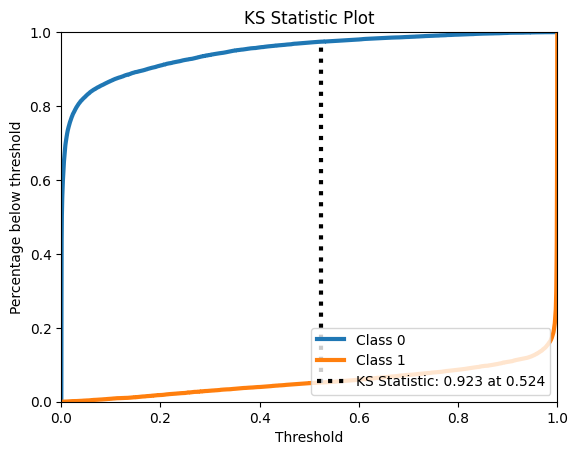

[I 2024-07-17 20:33:23,036] Trial 9 finished with value: 0.9949985995003892 and parameters: {'max_depth': 11, 'eta': 0.3, 'lambda': 1, 'alpha': 4, 'grow_policy': 'lossguide'}. Best is trial 6 with value: 0.9950711172733429.




Random Forest
eta: 0.3
max_depth:11
lambda:1
alpha:4
grow_policy:lossguide

Accuracy:         0.9623
Recall:           0.9498
Precision:        0.9629
F1:               0.9563
AUROC:            0.9950
AUPR:             0.9941


In [54]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

#### Salvando os resultados no csv e visualizando os resultados

In [56]:
df = study.trials_dataframe()
df = df[df["state"] == "COMPLETE"].drop(["datetime_start", "datetime_complete", "duration", "state"], axis=1)
df = df.sort_values("value")  # Sort based on accuracy

csv_file = "optuna_results_xgb.csv"
df_existing = pd.read_csv(csv_file) if os.path.isfile(csv_file) else None

df_existing = pd.concat([df_existing, df], ignore_index=True) if df_existing is not None else df
df_existing.to_csv(csv_file, index=False)

In [57]:
df_existing.sort_values("user_attrs_auroc")

,number,value,params_alpha,params_eta,params_grow_policy,params_lambda,params_max_depth,user_attrs_accuracy,user_attrs_alpha,user_attrs_auroc,user_attrs_eta,user_attrs_f1,user_attrs_grow_policy,user_attrs_lambda,user_attrs_max_depth,user_attrs_precision,user_attrs_recall
1,1,0.994236,2,0.20,lossguide,2,5,0.959994,2,0.994236,0.20,0.962784,lossguide,2,5,0.962784,0.944425
3,3,0.994595,4,0.05,lossguide,4,44,0.961749,4,0.994595,0.05,0.965213,lossguide,4,44,0.965213,0.946055
7,7,0.994617,3,0.05,depthwise,4,40,0.961380,3,0.994617,0.05,0.964108,depthwise,4,40,0.964108,0.946339
5,5,0.994648,1,0.10,depthwise,2,40,0.961287,1,0.994648,0.10,0.962630,depthwise,2,40,0.962630,0.947686
0,0,0.994775,1,0.20,depthwise,2,36,0.961934,1,0.994775,0.20,0.963753,depthwise,2,36,0.963753,0.948040
8,8,0.994951,5,0.15,depthwise,2,10,0.963043,5,0.994951,0.15,0.966664,depthwise,2,10,0.966664,0.947615
4,4,0.994974,2,0.25,depthwise,3,36,0.962488,2,0.994974,0.25,0.964938,depthwise,3,36,0.964938,0.948111
2,2,0.994993,4,0.15,lossguide,2,47,0.962766,4,0.994993,0.15,0.964893,lossguide,2,47,0.964893,0.948820
9,9,0.994999,4,0.30,lossguide,1,11,0.962304,4,0.994999,0.30,0.962918,lossguide,1,11,0.962918,0.949812
6,6,0.995071,5,0.20,lossguide,3,22,0.963228,5,0.995071,0.20,0.965669,lossguide,3,22,0.965669,0.949103


In [58]:
best_trial = study.best_trial
print("\n-- Best Trial --")
print(f"  Accuracy:  {best_trial.value}")
print(f"  Precision: {best_trial.user_attrs['precision']}")
print(f"  Recall:    {best_trial.user_attrs['recall']}")
print(f"  F1 Score:  {best_trial.user_attrs['f1']}")
print(f"  auroc:  {best_trial.user_attrs['auroc']}")

print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(16 - len(key)) * ' '}{val}")


print(f"\n-- Overall Results (Ordered by auroc) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(study, target=None)

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(15 - len(key)) * ' '}{(100 * val):.2f}%")


-- Best Trial --
  Accuracy:  0.9950711172733429
  Precision: 0.9656689505950234
  Recall:    0.9491032820585525
  F1 Score:  0.9656689505950234
  auroc:  0.9950711172733429
  Parameters: 
    max_depth:        22
    eta:              0.2
    lambda:           3
    alpha:            5
    grow_policy:      lossguide

-- Overall Results (Ordered by auroc) --
   number     value  params_alpha  params_eta params_grow_policy  \
1       1  0.994236             2        0.20          lossguide   
3       3  0.994595             4        0.05          lossguide   
7       7  0.994617             3        0.05          depthwise   
5       5  0.994648             1        0.10          depthwise   
0       0  0.994775             1        0.20          depthwise   
8       8  0.994951             5        0.15          depthwise   
4       4  0.994974             2        0.25          depthwise   
2       2  0.994993             4        0.15          lossguide   
9       9  0.994999      